In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# read data into memory
data_set = np.genfromtxt("hw04_data_set.csv", skip_header=1, delimiter = ",")

# get X and y values
X = data_set[:,0]
y = data_set[:,-1].astype(int)

X_train = X[:100]
y_train = y[:100]
X_test = X[100:]
y_test = y[100:]

# get numbers of train and test samples
N_train = len(y_train)
N_test = len(y_test)

In [3]:
def learn_algo(P):
        # create necessary data structures
    node_indices = {}
    is_terminal = {}
    need_split = {}

    node_splits = {}
    node_means = {}

    # put all training instances into the root node
    node_indices[1] = np.array(range(N_train))
    is_terminal[1] = False
    need_split[1] = True
    while True:
        # find nodes that need splitting
        split_nodes = [key for key, value in need_split.items() if value == True]
        # check whether we reach all terminal nodes
        if len(split_nodes) == 0:
            break
        # find best split positions for all nodes
        for split_node in split_nodes:
            data_indices = node_indices[split_node]
            need_split[split_node] = False
            node_mean = np.mean((y_train[data_indices]))
            if len((X_train[data_indices])) <= P:
                is_terminal[split_node] = True
                node_means[split_node] = node_mean
            else:
                is_terminal[split_node] = False

                unique_values = np.sort(np.unique(X_train[data_indices]))
                l = len(unique_values)
                split_positions = (unique_values[1:len(unique_values)] + unique_values[0:(len(unique_values) - 1)]) / 2
                split_scores = np.repeat(0, len(split_positions))

                for s in range(len(split_positions)):
                    left_indices = data_indices[X_train[data_indices] <= split_positions[s]]
                    right_indices = data_indices[X_train[data_indices] > split_positions[s]]
                    total_err = 0
                    e = 0
                    if len(left_indices) > 0:
                        total_err += np.sum((y_train[left_indices] - np.mean(y_train[left_indices]))**2)
                    if len(right_indices) > 0:
                        total_err += np.sum((y_train[right_indices] - np.mean(y_train[right_indices]))**2)
                    split_scores[s] = total_err / (len(left_indices) + len(right_indices)+1)

                if len(unique_values) == 1:
                    is_terminal[split_node] = True
                    node_means[split_node] = node_mean
                    continue

                best_split = split_positions[np.argmin(split_scores)]
                node_splits[split_node] = best_split

                # create left node using the selected split
                left_indices = data_indices[X_train[data_indices] < best_split]
                node_indices[2 * split_node] = left_indices
                is_terminal[2 * split_node] = False
                need_split[2 * split_node] = True

                # create right node using the selected split
                right_indices = data_indices[X_train[data_indices] >= best_split]
                node_indices[2 * split_node + 1] = right_indices
                is_terminal[2 * split_node + 1] = False
                need_split[2 * split_node + 1] = True
    return is_terminal, node_splits, node_means

In [4]:
def predict(point, is_terminal, node_splits, node_means):
    index = 1
    while(True):
        if is_terminal[index] == True:
            return node_means[index]
        else:
            if point <= node_splits[index]:
                index = 2*index
            else:
                index = 2*index + 1

In [5]:
data_points = np.linspace(np.min(X), np.max(X), 1000)

P_15 = 15
is_terminal, node_splits, node_means = learn_algo(P_15)

y_pred = [ predict(data_points[i], is_terminal, node_splits, node_means) for i in range(len(data_points))]

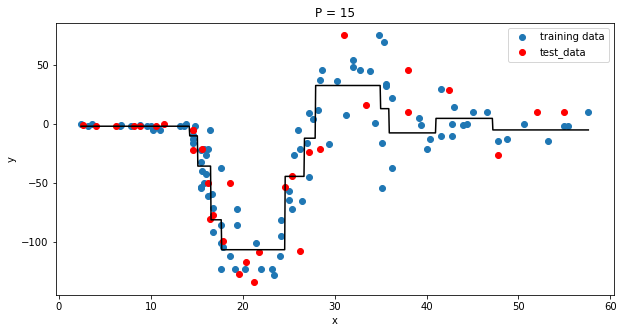

In [6]:
plt.figure(figsize=(10,5))
plt.title(f"P = {P_15}")
plt.scatter(X_train, y_train, label="training data")
plt.scatter(X_test, y_test, color="red", label="test_data")
plt.plot(data_points, y_pred, "k")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

In [7]:
y_pred = [ predict(X_test[i], is_terminal, node_splits, node_means) for i in range(N_test)]
rmse = np.sqrt(np.mean((y_test - y_pred)**2))
print(f"RMSE is {rmse} when P is {P_15}")

RMSE is 26.773045498327598 when P is 15


In [8]:
P = np.arange(5,51,5)
y_preds = np.zeros((len(P), N_test))
for p in range(len(P)):
    is_terminal, node_splits, node_means = learn_algo(P[p])
    y_pred = [ predict(X_test[i], is_terminal, node_splits, node_means) for i in range(N_test)]
    y_preds[p] = y_pred

rmse = [np.sqrt(np.mean((y_test - y_preds[i])**2)) for i in range(10)]

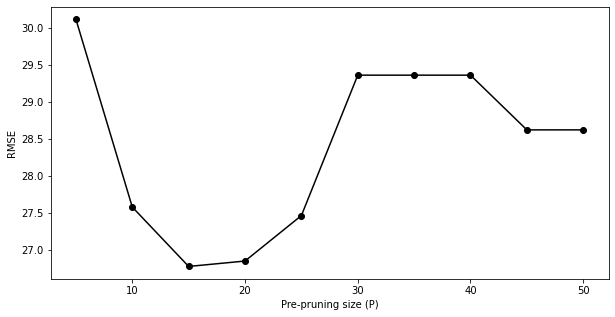

In [9]:
plt.figure(figsize=(10,5))
plt.scatter(P, rmse, color="black")
plt.plot(P, rmse, color="black")
plt.xlabel("Pre-pruning size (P)")
plt.ylabel("RMSE")
plt.show()